## ACCRE


### Questions from Eric:

### 1) What groups are best optimizing their memory usage in terms of percent of actual memory used vs. memory requested for the job? What is the average percent for each group?

Note: 
    When Eric says "group" is he referring to "research groups" (which could be indicated by one or more account IDs), job groups (job IDs in an array), or partition groups?
    

### 2) Optimizing memory is more important for longer running jobs than shorter running jobs, as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group? 
Note: Recall that high throughput computing (HTC) is focused on the use of multiple resources over long periods of time.

### 3) We are concerned with potentially unreliable notes which are not being detected by routine monitoring.  Of the jobs that failed, do any nodes show up unusually often?

Tip: Ignore debug partition. Look for failed jobs.

Note: Consider his use of "unusually often"

### 4) The CMS collaboration submits jobs that will run internal diagnostics and intentionally end early in 30 minutes. How often is this happening? (ie: what percent of jobs are CMS jobs) And does it happen on the same nodes repeatedly?

Tip: Check both 'production' and 'nogpfs' partitions. Look for commonly failing nodes and compare with other failed jobs. 

Note: 
    Filter df with below parameters:
        - Only production and nogpfs partitions 
        - State = 'cancelled'
        - Usedtime = 30 minutes
    Count number of unique job ids fall into this criteria
    Compare to total number of unique job ids

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
import re

## Column renames ---> 1) nodelist, 2)nodelist nonproduction

#### Read in the data. The Nodes column triggers errors because several values are spread out over multiple other columns to the right.

In [2]:
#accre = pd.read_csv('../data/accre-jobs-2020.csv',names=['JOBID', 'ACCOUNT', 'USER', 'REQMEM', 'USEDMEM', 'REQTIME', 'USEDTIME',
       #'NODES', 'CPUS', 'PARTITION', 'EXITCODE', 'STATE', 'NODELIST'])

#MP's previous suggestion for how to read in the file by identifying which columns to include. Resulted in adding additional row with column names as row values

In [3]:
accre = pd.read_csv('../data/accre-jobs-2020-updated-nodes.txt', low_memory = False)

In [4]:
accre.head()

,jobid,nodelist,node_non_prod,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state
0,16601402,dougherty1,NaN,mickey,dequan,126976Mn,33829.39M,20-20:00:00,20-20:00:22,1,24,cgw-dougherty1,0:0,COMPLETED
1,16724750,capra1,NaN,fava,jimena,102400Mn,70400.58M,12-12:00:00,12-12:00:25,1,1,cgw-capra1,0:0,COMPLETED
2,16930298,cqs1,NaN,mangosteen,shenna,40960Mn,2074.28M,8-08:00:00,8-00:42:41,1,4,cgw-cqs1,0:0,COMPLETED
3,16950679,gpu0028,NaN,sprite,averi,15360Mn,2794.42M,5-00:00:00,5-00:00:09,1,1,pascal,0:0,COMPLETED
4,16959412,cqs1,NaN,mangosteen,shenna,40960Mn,1839.84M,8-08:00:00,7-03:34:54,1,4,cgw-cqs1,0:0,COMPLETED


In [6]:
#examining range of rows during group discussion
#accre.iloc[3449:3471,:]

In [7]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864905 entries, 0 to 3864904
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   jobid          object 
 1   nodelist       object 
 2   node_non_prod  float64
 3   account        object 
 4   user           object 
 5   reqmem         object 
 6   usedmem        object 
 7   reqtime        object 
 8   usedtime       object 
 9   nodes          int64  
 10  cpus           int64  
 11  partition      object 
 12  exitcode       object 
 13  state          object 
dtypes: float64(1), int64(2), object(11)
memory usage: 412.8+ MB


### Convert column names to lowercase

#### Rename nodelist and node_non_prod from Alvin

In [8]:
accre.rename(columns={'nodelist':'node_non_prod', 'node_non_prod':'nodelist'},inplace = True)

In [10]:
accre.columns

Index(['jobid', 'node_non_prod', 'nodelist', 'account', 'user', 'reqmem',
       'usedmem', 'reqtime', 'usedtime', 'nodes', 'cpus', 'partition',
       'exitcode', 'state'],
      dtype='object')

In [11]:
#make column names lowercase, per group discussion
#accre.columns = accre.columns.str.lower()

In [12]:
accre.usedtime.sort_values()

147525       00:00:00
337810       00:00:00
142274       00:00:00
148730       00:00:00
142275       00:00:00
              ...    
3008103    9-22:57:28
3677119    9-23:11:36
3677120    9-23:11:50
893849     9-23:27:11
226778     9-23:34:43
Name: usedtime, Length: 3864905, dtype: object

In [13]:
accre.usedtime.describe()

count      3864905
unique      164323
top       00:00:07
freq         42584
Name: usedtime, dtype: object

### Job time is in a format of either d-hh:mm:ss or hh:mm:ss. Convert to seconds.

In [14]:
#Convert the times into seconds

def convert_time_to_seconds(time):
    """Return an integer value of the time converted into seconds."""
    
    #Identify values not formatted as d-hh:mm:ss. Fill in the hour value by appending '0-' on the left of the string. 
    #This will make all our strings cleanly parse into an equal number of substrings.
    
    if len(time) <9:
        time = "0-" + time
    else: time
    
    #Use regex to select either '-' OR ':' as delimiter for split. The resulting substring list is ordered as [days, hours, minutes, seconds]
    #Cast the list of substrings to numeric, turning it into an array. Cleaner to do it here than for each individual substring
    time = pd.to_numeric(re.split('[-|:]',time))

    #Add the product of each unit and its multiplier to get the total time in seconds
    
    time_in_seconds = time[-4]*86400 + time[-3]*3600 + time[-2]*60 + time[-1]
    
    return time_in_seconds

In [15]:
#Change existing time columns to time in seconds.
accre['reqtime'] = accre['reqtime'].apply(convert_time_to_seconds)
accre['usedtime'] = accre['usedtime'].apply(convert_time_to_seconds)

In [16]:
#Create new columns to reflect difference between requested time and used time.
#Values - in seconds
accre['time_diff'] = accre['reqtime'] - accre['usedtime']
#Percent
accre['time_pct_used'] = accre['usedtime'] / accre['reqtime'] * 100

In [18]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864905 entries, 0 to 3864904
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   jobid          object 
 1   node_non_prod  object 
 2   nodelist       float64
 3   account        object 
 4   user           object 
 5   reqmem         object 
 6   usedmem        object 
 7   reqtime        int64  
 8   usedtime       int64  
 9   nodes          int64  
 10  cpus           int64  
 11  partition      object 
 12  exitcode       object 
 13  state          object 
 14  time_diff      int64  
 15  time_pct_used  float64
dtypes: float64(2), int64(5), object(9)
memory usage: 471.8+ MB


In [19]:
accre.head()

,jobid,node_non_prod,nodelist,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,time_diff,time_pct_used
0,16601402,dougherty1,NaN,mickey,dequan,126976Mn,33829.39M,1800000,1800022,1,24,cgw-dougherty1,0:0,COMPLETED,-22,100.001222
1,16724750,capra1,NaN,fava,jimena,102400Mn,70400.58M,1080000,1080025,1,1,cgw-capra1,0:0,COMPLETED,-25,100.002315
2,16930298,cqs1,NaN,mangosteen,shenna,40960Mn,2074.28M,720000,693761,1,4,cgw-cqs1,0:0,COMPLETED,26239,96.355694
3,16950679,gpu0028,NaN,sprite,averi,15360Mn,2794.42M,432000,432009,1,1,pascal,0:0,COMPLETED,-9,100.002083
4,16959412,cqs1,NaN,mangosteen,shenna,40960Mn,1839.84M,720000,617694,1,4,cgw-cqs1,0:0,COMPLETED,102306,85.790833


In [20]:
#accre.time_diff.value_counts()

In [21]:
#accre.time_diff.unique()

In [22]:
#accre.time_diff.hist(bins=50)

### Exitcode has two values. 0:0 indicates a successful job. Split into two columns.
Nonzero on the right - issue with the job itself or node (eg: out of memory, node failure, job cancelled)
Nonzero on the left - issue with the user's software

In [23]:
#accre.exitcode.value_counts()

In [24]:
accre[['exitcode_user', 'exitcode_node']] = accre['exitcode'].str.split(':', expand=True).astype(int)

In [25]:
#accre.sample(5)

### Memory is reported in terms of Megabytes per node (Mc) or Megabytes per core (Mc), this needs to be uniformly converted to Megabytes per core by dividing by the number of cores per node in a job. 

Note: CPUS column includes total number of CPU cores allocated to a job (even for multi-node jobs). 
    WHEN reqmem column includes Mn AND in the entire usemem column
    Memory (CPUs / Nodes)


In [26]:
#Separate digits from suffixes Mn and Mc. Save numbers to reqmemory column and suffixes to core_node column.
accre[['reqmemory', 'core_node']] = accre['reqmem'].str.split('M', expand=True)
accre['reqmemory'] = accre['reqmemory'].astype(int)

In [27]:
#Convert requested memory column to 'by core'
accre['reqmemory'] = np.where(
    accre['core_node']=='n', accre['reqmemory'] / accre['cpus'] / accre['nodes'], 
accre['reqmemory']
)

In [28]:
#Remove M suffix in requested memory column. Save as float and convert to memory per core
accre['usedmemory'] = accre['usedmem'].str.replace(r'M*', '').astype(float)
accre['usedmemory'] = round(accre['usedmemory'] / accre['cpus'] / accre['nodes'], 1)

In [29]:
#Calculate difference in requested time vs used time. Save to new columns for actual values and percentages
#Values
accre['mem_diff'] = accre['reqmemory'] - accre['usedmemory']
#Percent
accre['mem_pct_used'] = accre['usedmemory'] / accre['reqmemory'] * 100

In [30]:
accre.sample(10)

,jobid,node_non_prod,nodelist,account,user,reqmem,usedmem,reqtime,usedtime,nodes,...,state,time_diff,time_pct_used,exitcode_user,exitcode_node,reqmemory,core_node,usedmemory,mem_diff,mem_pct_used
3125637,22593157,NaN,1465.0,summer,buddy,20480Mc,7815.02M,5400,1892,1,...,COMPLETED,3508,35.037037,0,0,20480.000000,c,7815.0,12665.000000,38.159180
3535770,23495318,NaN,1266.0,cms,cmslocal,5000Mn,6.23M,172800,1204,1,...,COMPLETED,171596,0.696759,0,0,5000.000000,n,6.2,4993.800000,0.124000
2096789,20166700,NaN,1491.0,summer,buddy,12288Mn,7852.32M,5400,1830,1,...,COMPLETED,3570,33.888889,0,0,12288.000000,n,7852.3,4435.700000,63.902181
2717578,21575136_6653,NaN,1315.0,casaba,anne,8192Mc,932.68M,7200,1233,1,...,COMPLETED,5967,17.125000,0,0,8192.000000,c,932.7,7259.300000,11.385498
1430579,18777009,NaN,1465.0,summer,buddy,20480Mn,17561.05M,10800,2030,1,...,COMPLETED,8770,18.796296,0,0,6826.666667,n,5853.7,972.966667,85.747559
3038699,22406544_13,NaN,454.0,orange,birt,8000Mn,940.81M,43200,786,1,...,COMPLETED,42414,1.819444,0,0,8000.000000,n,940.8,7059.200000,11.760000
935092,17812129_15,NaN,1277.0,cep,gertrude,4096Mn,1977.54M,230400,140182,1,...,COMPLETED,90218,60.842882,0,0,4096.000000,n,1977.5,2118.500000,48.278809
21584,17254453,ng688,NaN,cms,cmslocal,21880Mn,1.84M,172800,1241,1,...,COMPLETED,171559,0.718171,0,0,2735.000000,n,0.2,2734.800000,0.007313
1660783,19243522,NaN,1479.0,summer,buddy,12288Mn,8507.95M,5400,1837,1,...,COMPLETED,3563,34.018519,0,0,12288.000000,n,8508.0,3780.000000,69.238281
2040881,20022390,NaN,1345.0,cms_lowprio,cmslocal,5000Mn,1700.14M,172800,27494,1,...,COMPLETED,145306,15.910880,0,0,5000.000000,n,1700.1,3299.900000,34.002000


### If time allows filter out situations with number of nodes is greater than cpus

In [31]:
accre[(accre['nodes'] > 1) &(accre['cpus']== 1)]
#Index 3576 - if CPUs is "total number of CPU cores allocated to the job", then how can one CPU core operate over three nodes?

,jobid,node_non_prod,nodelist,account,user,reqmem,usedmem,reqtime,usedtime,nodes,...,state,time_diff,time_pct_used,exitcode_user,exitcode_node,reqmemory,core_node,usedmemory,mem_diff,mem_pct_used
44611,17427722,gpu[0037-0040],NaN,endive,asbury,16384Mn,1617.33M,1800,1844,4,...,CANCELLED,-44,102.444444,0,9,4096.0,n,404.3,3691.7,9.870605
73273,17701006,gpu[0025-0026],NaN,turban,hardie,122880Mn,38340.87M,72000,42356,2,...,COMPLETED,29644,58.827778,0,0,61440.0,n,19170.4,42269.6,31.201823
73719,17703723,gpu[0028-0030],NaN,turban,hardie,122880Mn,19.89M,36000,157,3,...,FAILED,35843,0.436111,1,0,40960.0,n,6.6,40953.4,0.016113
73720,17703726,gpu[0028-0030],NaN,turban,hardie,122880Mn,19.85M,36000,42,3,...,FAILED,35958,0.116667,1,0,40960.0,n,6.6,40953.4,0.016113
73722,17703730,gpu[0028-0029],NaN,turban,hardie,122880Mn,17.89M,36000,676,2,...,FAILED,35324,1.877778,1,0,61440.0,n,8.9,61431.1,0.014486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651934,23681412,NaN,1369.0,burro,kate,12288Mn,12041.67M,36000,17455,4,...,COMPLETED,18545,48.486111,0,0,3072.0,n,3010.4,61.6,97.994792
3680760,23771642,NaN,1121.0,alkmene,abigail,1024Mc,0,14400,1,2,...,FAILED,14399,0.006944,2,0,1024.0,c,0.0,1024.0,0.000000
3680761,23771642,NaN,1122.0,alkmene,abigail,1024Mc,0,14400,1,2,...,FAILED,14399,0.006944,2,0,1024.0,c,0.0,1024.0,0.000000
3684013,23793364,NaN,911.0,alkmene,abigail,100Mc,3.18M,3600,3612,2,...,FAILED,-12,100.333333,7,0,100.0,c,1.6,98.4,1.600000


In [32]:
#Adjust order of columns in dataframe. 
#Drop original exitcode, reqmem and usedmem columns and the helper core_node column.

accre = accre[['jobid', 'account', 'user','reqmemory','usedmemory', 'mem_diff', 'mem_pct_used', 'reqtime', 'usedtime',
       'time_diff', 'time_pct_used','nodes', 'cpus', 'partition', 'exitcode_user', 'exitcode_node', 'state', 
        'nodelist']]

In [33]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864905 entries, 0 to 3864904
Data columns (total 18 columns):
 #   Column         Dtype  
---  ------         -----  
 0   jobid          object 
 1   account        object 
 2   user           object 
 3   reqmemory      float64
 4   usedmemory     float64
 5   mem_diff       float64
 6   mem_pct_used   float64
 7   reqtime        int64  
 8   usedtime       int64  
 9   time_diff      int64  
 10  time_pct_used  float64
 11  nodes          int64  
 12  cpus           int64  
 13  partition      object 
 14  exitcode_user  int64  
 15  exitcode_node  int64  
 16  state          object 
 17  nodelist       float64
dtypes: float64(6), int64(7), object(5)
memory usage: 530.8+ MB


In [34]:
#Code to groupby to find mean of each account
#accre.groupby('account')[['account', 'mem_pct_used']].mean().sort_values('mem_pct_used')

## Save to CSV and export

In [38]:
accre.to_csv('../data/accre-jobs-2020-cleaned.csv', index = False)

### Remove rows with values other than "production" in the Partition column.
"We really only want to look at the "production" partition so rows with other partitions should be removed"

#### However, we probably want to do this AFTER cleaning all the data. One of Eric's questions requests examining data where partition = 'nogpfs'

In [37]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864905 entries, 0 to 3864904
Data columns (total 18 columns):
 #   Column         Dtype  
---  ------         -----  
 0   jobid          object 
 1   account        object 
 2   user           object 
 3   reqmemory      float64
 4   usedmemory     float64
 5   mem_diff       float64
 6   mem_pct_used   float64
 7   reqtime        int64  
 8   usedtime       int64  
 9   time_diff      int64  
 10  time_pct_used  float64
 11  nodes          int64  
 12  cpus           int64  
 13  partition      object 
 14  exitcode_user  int64  
 15  exitcode_node  int64  
 16  state          object 
 17  nodelist       float64
dtypes: float64(6), int64(7), object(5)
memory usage: 530.8+ MB


In [35]:
#Check the distribution of partition values
accre.partition.value_counts(normalize=True)

production              8.694659e-01
nogpfs                  8.477621e-02
sam                     2.047942e-02
pascal                  1.242049e-02
turing                  1.019585e-02
debug                   1.743380e-03
maxwell                 8.662567e-04
cgw-capra1              2.147530e-05
cgw-dougherty1          1.862918e-05
cgw-cqs1                8.797111e-06
cgw-vm-qa-flatearth1    1.034954e-06
cgw-cqs3                1.034954e-06
cgw-rocksteady          5.174771e-07
devel                   5.174771e-07
cgw-tbi01               5.174771e-07
Name: partition, dtype: float64

In [36]:
#Include everything BUT production data and save as new df.
accre_nonprod = accre[accre['partition']!='production'].reset_index(drop = True)
accre_nonprod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504502 entries, 0 to 504501
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   jobid          504502 non-null  object 
 1   account        504502 non-null  object 
 2   user           504502 non-null  object 
 3   reqmemory      504502 non-null  float64
 4   usedmemory     504502 non-null  float64
 5   mem_diff       504494 non-null  float64
 6   mem_pct_used   504494 non-null  float64
 7   reqtime        504502 non-null  int64  
 8   usedtime       504502 non-null  int64  
 9   time_diff      504502 non-null  int64  
 10  time_pct_used  504502 non-null  float64
 11  nodes          504502 non-null  int64  
 12  cpus           504502 non-null  int64  
 13  partition      504502 non-null  object 
 14  exitcode_user  504502 non-null  int64  
 15  exitcode_node  504502 non-null  int64  
 16  state          504502 non-null  object 
 17  nodelist       0 non-null    

In [32]:
accre_nonprod[accre_nonprod['partition']=='nogpfs'].sample(25)

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_diff_pct,reqtime,usedtime,time_diff,time_diff_pct,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist
1682,17095168,cms,cmslocal,2734.375000,0.2,2734.175000,0.007314,172800,1241,171559,0.718171,1,8,nogpfs,0,0,COMPLETED,ng1027
276,17072866,cms,cmspilot,3582.833333,2237.2,1345.633333,62.442201,172800,169659,3141,98.182292,1,12,nogpfs,0,0,COMPLETED,ng213
1564,17094541,cms,cmspilot,2734.375000,1372.0,1362.375000,50.176000,172800,165448,7352,95.745370,1,8,nogpfs,0,0,COMPLETED,ng908
1424,17089621,cms,cmslocal,2734.375000,1422.5,1311.875000,52.022857,172800,25323,147477,14.654514,1,8,nogpfs,0,0,COMPLETED,ng1015
1484,17093938,cms,cmslocal,2734.750000,1748.4,986.350000,63.932718,172800,3153,169647,1.824653,1,8,nogpfs,0,0,COMPLETED,ng744
39,17051128,cms,cmspilot,4750.875000,3663.5,1087.375000,77.112111,172800,155588,17212,90.039352,1,8,nogpfs,0,0,COMPLETED,ng512
265,17072843,cms,cmspilot,3582.833333,2030.2,1552.633333,56.664651,172800,167094,5706,96.697917,1,12,nogpfs,0,0,COMPLETED,ng207
1436,17093438,cms,cmslocal,2735.000000,0.0,2735.000000,0.000000,172800,5524,167276,3.196759,1,8,nogpfs,0,0,COMPLETED,ng914
1445,17093477,cms,cmslocal,2735.000000,0.2,2734.800000,0.007313,172800,1319,171481,0.763310,1,8,nogpfs,0,0,COMPLETED,ng678
251,17072819,cms,cmspilot,2231.000000,1692.8,538.200000,75.876289,172800,165819,6981,95.960069,1,8,nogpfs,0,0,COMPLETED,ng505


In [33]:
#Exclude everything other than production data and use Boolean mask and save accre df back to itself.
accre = accre[accre['partition']=='production'].reset_index(drop = True)
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   jobid          7274 non-null   object 
 1   account        7274 non-null   object 
 2   user           7274 non-null   object 
 3   reqmemory      7274 non-null   float64
 4   usedmemory     7274 non-null   float64
 5   mem_diff       7274 non-null   float64
 6   mem_diff_pct   7274 non-null   float64
 7   reqtime        7274 non-null   int64  
 8   usedtime       7274 non-null   int64  
 9   time_diff      7274 non-null   int64  
 10  time_diff_pct  7274 non-null   float64
 11  nodes          7274 non-null   int64  
 12  cpus           7274 non-null   int64  
 13  partition      7274 non-null   object 
 14  exitcode_user  7274 non-null   int64  
 15  exitcode_node  7274 non-null   int64  
 16  state          7274 non-null   object 
 17  nodelist       7274 non-null   object 
dtypes: float

In [34]:
accre.sample(15)

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_diff_pct,reqtime,usedtime,time_diff,time_diff_pct,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist
4886,17075432_28,cep,codie,4096.0,1715.4,2380.6,41.879883,604800,171162,433638,28.300595,1,1,production,0,0,COMPLETED,cn1452
263,16849298_2383,minnewashta,jenniffer,16384.0,581.6,15802.4,3.549805,252000,131165,120835,52.049603,1,1,production,0,0,COMPLETED,cn1375
1249,17021284_217,regal,debbra,16384.0,989.0,15395.0,6.036377,540000,189893,350107,35.165370,1,1,production,0,0,COMPLETED,cn340
1246,17021284_214,regal,debbra,16384.0,1230.5,15153.5,7.510376,540000,197031,342969,36.487222,1,1,production,0,0,COMPLETED,cn405
1029,17016721_59,sunburst,darlyne,8192.0,2253.6,5938.4,27.509766,1209600,627739,581861,51.896412,1,1,production,0,0,COMPLETED,cn473
4147,17063541,cms,cmspilot,7000.0,3513.7,3486.3,50.195714,172800,145906,26894,84.436343,1,4,production,0,0,COMPLETED,cn357
5588,17089441_7,cep,hoy,1024.0,518.9,505.1,50.673828,90000,74794,15206,83.104444,1,1,production,0,0,COMPLETED,cn1313
3036,17045075_781,winged,lavona,4096.0,282.7,3813.3,6.901855,345600,69965,275635,20.244502,1,1,production,0,0,COMPLETED,cn1476
3194,17045075_939,winged,lavona,4096.0,225.9,3870.1,5.515137,345600,74173,271427,21.462095,1,1,production,0,0,COMPLETED,cn1420
2283,17043147,wood,hillery,600.0,156.7,443.3,26.116667,212280,212297,-17,100.008008,1,1,production,0,0,COMPLETED,cn1285


### 2) Optimizing memory is more important for longer running jobs than shorter running jobs, as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group?¶
Note: Recall that high throughput computing (HTC) is focused on the use of multiple resources over long periods of time.

Jobs that run for longer periods of time should carry more weight.

In [36]:
accre.time_pct_used.describe()

count    7274.000000
mean       40.397345
std        33.207312
min         0.000661
25%        15.543547
50%        26.371528
75%        73.738318
max       128.160185
Name: time_diff_pct, dtype: float64

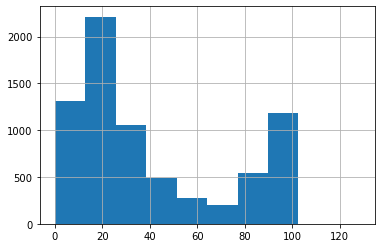

In [38]:
accre.time_pct_used.hist()

In [39]:
accre.usedtime.describe()

count    7.274000e+03
mean     1.365410e+05
std      1.614047e+05
min      8.000000e+00
25%      2.747475e+04
50%      8.417800e+04
75%      1.757140e+05
max      1.522543e+06
Name: usedtime, dtype: float64

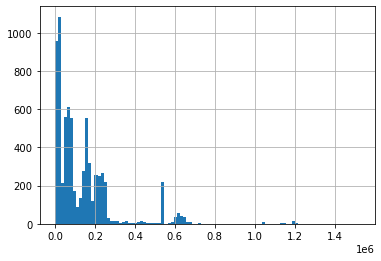

In [40]:
accre.usedtime.hist(bins = 100)

In [37]:
accre.head()

,index,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_diff_pct,reqtime,usedtime,time_diff,time_diff_pct,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist
0,0,15925210,treviso,arabella,5120.0,2748.9,2371.1,53.689453,1188000,1188028,-28,100.002357,1,24,production,0,0,COMPLETED,cn1531
1,1,15861126,treviso,arabella,5120.0,2799.2,2320.8,54.671875,1188000,1090256,97744,91.772391,1,24,production,0,0,COMPLETED,cn1441
2,2,15861125,treviso,arabella,5120.0,2879.7,2240.3,56.244141,1188000,1188020,-20,100.001684,1,24,production,0,0,COMPLETED,cn1464
3,3,16251645,treviso,arabella,5120.0,2721.6,2398.4,53.156250,1188000,1050632,137368,88.437037,1,24,production,0,0,COMPLETED,cn1473
4,4,16251646,treviso,arabella,5120.0,2744.8,2375.2,53.609375,1188000,1188003,-3,100.000253,1,24,production,0,0,COMPLETED,cn1440


In [ ]:
#Create a column of each job's weighted percentage of memory use.
accre['weighted_mem'] = accre['mem_pct_used'] * accre['reqtime'] / accre['reqtime'].sum()

#Group weighted averages and find mean per account.
accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'weighted_mem']].mean().sort_values('weighted_mem').head(10)

In [43]:
accre[['reqtime', 'mem_pct_used', 'weighted_mem']] .sort_values('mem_pct_used').iloc[3200000:3200010]

KeyError: "['weighted_mem'] not in index"

In [34]:
#accre[['exitcode_user', 'exitcode_node']] = accre['exitcode'].str.split(':', expand=True).astype(int)

In [28]:
accre[accre['state']!='COMPLETED']['state'].value_counts()

CANCELLED    13
FAILED        2
Name: state, dtype: int64

### Slice off to create dataframe with records only related to node failures.
MP shared code on 10/3 

In [19]:
#accre[['exitcode_user', 'exitcode_node']] = accre['exitcode'].str.split(':', expand=True).astype(int)
#new DF only including records with node failures. 
#accre_node_failure = accre.loc[accre['exitcode_node'] != 0]

In [19]:
accre.state.nunique()

1

In [20]:
accre.state.unique()

array(['COMPLETED'], dtype=object)

In [21]:
accre.NODES.nunique()

94

In [22]:
accre.NODES.value_counts()

1     3745514
1       65391
2        2459
3         861
4         579
       ...   
51          1
44          1
43          1
41          1
61          1
Name: NODES, Length: 94, dtype: int64

In [34]:
accre[accre.NODES==1].nunique()

JOBID        3745514
ACCOUNT          172
USER             594
REQMEM           204
USEDMEM       827081
REQTIME          448
USEDTIME      161540
NODES              1
CPUS              23
PARTITION         15
EXITCODE          24
STATE             33
NODELIST         868
dtype: int64

In [36]:
accre[(accre.STATE=='FAILED')|(accre.STATE=='OUT_OF_MEMORY')].shape

(1500, 13)

## Scraps 
To be deleted/saved elsewhere

In [108]:


#pd.to_datetime returned error Unknown string format 13-18:00:00.  Replace the - with :

#accre['reqtime'] = accre['reqtime'].str.replace('-',':')
#accre['usedtime'] = accre['usedtime'].str.replace('-',':')

#create a placeholder column in order to view the original and updated values side by side
#accre['reqtime2'] = accre['reqtime']

#accre['reqtime2'] = pd.to_timedelta(accre['reqtime2'])

#Write & test if/else portion of formula. IF the string value in the column is shorter than 9 characters, then it means there is no hour data.
#Fill in the hour value by appending '0-' on the left of the string. This will make all our strings able to parse into an equal number of substrings.

#time = '1-22:16:15'

#if len(time) <9:
    #time = "0-" + time
#else: time

#Use regex to select either '-' OR ':' as delimiter for split
#Cast substring to numeric, turning it into an array. Cleaner to do it here than for each individual substring

#substring = pd.to_numeric(re.split('[-|:]',time))
#substring

#Separate each element of the array and save to variable representing unit of time
#Add the product of each variable and the multiplier to get the total time in seconds

#day = substring[-4]
#hours = substring[-3]
#minutes = substring[-2]
#seconds = substring[-1]

#time_in_seconds= day*86400 + hours*3600 + minutes*60 + seconds


#sample_df = {'job':['1','2','3','4','5'],'reqtime_test':['23:58:00','2-10:58:00','2-00:00:00','22:18:36','4-02:50:00'],'usedtime_test':['22:19:15','1-23:58:00','1-05:17:04','20:52:47','4-02:50:01']}
#sample_df = pd.DataFrame(sample_df,columns=['job','reqtime_test','usedtime_test'])
#sample_df

#sample_df['reqtime_seconds'] = sample_df['reqtime_test'].apply(convert_time_to_seconds)

#sample_df

#Define time_in_seconds()

#def convert_time_to_seconds(time):
    #"""Return an integer value of the time converted into seconds."""
    
    #Identify values not formatted as dhhmmss. Fill in the hour value by appending '0-' on the left of the string. 
    #This will make all our strings able to parse into an equal number of substrings.
    
    #if len(time) <9:
        #time = "0-" + time
   # else: time
    
    #Use regex to select either '-' OR ':' as delimiter for split
    #Cast the list of substrings to numeric, turning it into an array. Cleaner to do it here than for each individual substring
    #time = pd.to_numeric(re.split('[-|:]',time))

    #Separate each element of the array and save to variable representing unit of time
    #day = time[-4]
    #hours = time[-3]
    #minutes = time[-2]
    #seconds = time[-1]

    #Add the product of each unit and it's multiplier to get the total time in seconds
    #time_in_seconds= day*86400 + hours*3600 + minutes*60 + seconds
    
    #return time_in_seconds